<center><img src="../themes/aequitas_logo.png"/></center>
<center><figcaption>Fig.1 - Logo d'Aequitas</figcaption></center>

# 1. Introduction

**Aequitas** est un outil open-source d'audit de biais et de discrimination dans les modèles de machine learning.

## 1.1. Interface
Aequitas peut être utilisé via trois interfaces.
- Un **[package python](https://dssg.github.io/aequitas/using_python.html)**
- Une **[interface web](https://dssg.github.io/aequitas/30_seconds_webapp.html)** qui peut être utilisée soit à partir du site d'Aequitas soit localement.
- Une **[CLI](https://dssg.github.io/aequitas/CLI.html)**

Alors que les trois interfaces permettent de mener le même type d'analyse, la CLI et l'interface web permettent de générer des rapports d'analyse de biais très rapidement. Le package python est très pratique lors d'une analyse exploratoire du biais et lors de l'interaction avec d'autres packages.

Dans ce notebook, seules les fonctionnalités du package python seront présentées.

## 1.2. Données d'entrée

Pour le moment, Aequitas permet de mener des analyses seulement dans le cas de problématiques de **classification binaire**. 

En données d'entrée, Aequitas s'attend au moins à deux colonnes:

- **score**: Cette colonne doit correspondre à la sortie du modèle. 
    - Elle peut prendre comme valeur soit des **0/1 ou des probabilités**. 
    - En cas de probabilités, l'utilisateur doit fournir le seuil permettant de séparer les deux classes.
- **attribute**: Cette colonne correspond à la variable sensible. 
    - Aequitas permet d'analyser le biais avec **plusieurs variables sensibles** à la fois et *plusieurs colonnes* peuvent donc être fournies en entrée.
    - Aequitas ne prend que **des variables à protéger catégorielles**.
    - Les variables sensibles dépendent du cadre réglementaire et du contexte de l'analyse mais l'âge et le sexe sont des exemples de variables qui sont souvent considérées comme variables à protéger.
- **label_value**: correspond à la valeur réelle (ground-truth) de de l'output. Cette colonne n'est pas obligatoire mais le fait de la fournir permet de calculer plusieurs métriques en plus.


Mots réservés dans Aequitas: *score*, *label_value*, *id*, *model_id*, *entity_id*, *rank_abs* et *rank_pct*.

<center><img src="../themes/python_input.jpg"/></center>
<center><figcaption>Fig.2 - Données d'entrée pour Aequitas</figcaption></center>

## 1.3. Structure d'Aequitas

Aequitas contient 4 classes. Chacune de ces 4 classes a un rôle spécifique.

Dans la pratique, les trois classes suivantes sont utilisées l'une à la suite de l'autre.
- `Group`: Cette classe permet de **définir les variables à protéger** et de **calculer les métriques** de groupe dessus.
- `Bias`: Cette classe **calcule les disparités** entre les différents groupes, et ce à partir des résultats des métriques calculées par les méthodes de la classe `Group`.
- `Fairness`: Cette classe permet de **définir la mesure d'équité** et indique si la définition est respectée par l'output du modèle.

La dernière classe, en l'occurrence `Plot` contient plusieurs fonctions qui permettent d'obtenir rapidement **des visualisations adaptées** à l'output de chacune des classes ci-dessus.

# 2. Cas pratique - COMPAS

## 2.1. Contexte

**Disclaimer: Alors que l'analyse du dataset issu de l'outil COMPAS est un usecase classique dans l'analyse des biais des modèles, cet exemple s'inspire beaucoup de la documentation d'Aequitas ainsi que de plusieurs présentations de l'équipe d'Aequitas.**

*COMPAS* est un outil d'évaluation de risques d'individus qui est utilisé dans plusieurs états aux Etats-Unis. Le but de l'outil est d'évaluer les risques que peuvent présenter les individus et d'aider ainsi les juges à prendre **certains types de décisions** telle que la possibilité de mise en liberté provisoire sous caution.

En 2016, ProPublica a mené une investigation de l'impact de COMPAS et des biais qu'il présente. Pour plus d'éléments sur l'analyse menée par ProPublica du modèle utilisé dans l'outil COMPAS, n'hésitez pas à consulter:
- [Machine Bias: Risk Assessments in Criminal Sentencing](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)
- [Le dépôt github de l'analyse de ProPublica](https://github.com/propublica/compas-analysis)

<br>
<center><img src="../themes/propublica_article_fig.jpeg" width="500" height="auto"/></center>
<center><figcaption>Fig.3 - Bernard Parker, à gauche, évalué risque élevé; Dylan Fugett évalué risque bas</figcaption></center>


<center><a href="https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing">Source: ProPublica</a></center>


## 2.2. Jeu de données

COMPAS produit un score qui correspond au **risque de récidivisme**. Ce risque correspond au risque de commettre un crime dans les deux ans qui suivent.


Le **résultat de COMPAS** correspond à un score qui va de 1 à 10. Dans ce cas pratique, ce score a été converti à un score binaire, avec:
- Score de 0: Risque de récidivisme bas
- Score de 1: Risque de récidivisme élevé

Les **variables à protéger** dans ce cas pratique sont l'*âge*, le *sexe* et l'*origine ethnique*.

Le jeu de données à disposition est issu du dépôt Github d'Aequitas et est déjà dans le bon format pour Aequitas. Il correspond à deux ans de prédictions de COMPAS sur la population concernée parmi les habitants de Broward County, FL.

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [2]:
project_path = Path("..")
data_path = project_path/"datasets"

In [3]:
df_compas = pd.read_csv(data_path/"compas_for_aequitas.csv")
df_compas.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


## 2.3. Analyse exploratoire

Dans un premier temps, une analyse des distributions des modalités des différentes variables à protéger peut révéler plusieurs pistes/hypothèses à explorer. Cette analyse est loin d'être exhaustive.

### 2.3.1. Croisement avec le score

**Croisement de l'origine avec le score du modèle**

<AxesSubplot:xlabel='race'>

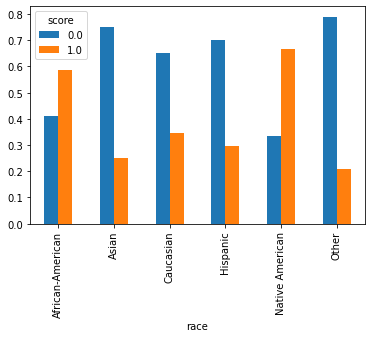

In [4]:
# Croisement origine ethnique - Score du modèle
(
    pd.crosstab(df_compas.race, df_compas.score, normalize="index")
    .plot.bar()
)

**Croisement du sexe avec le score du modèle**

<AxesSubplot:xlabel='sex'>

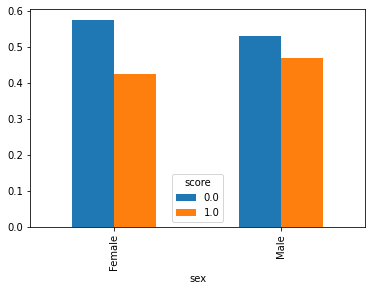

In [5]:
# Croisement Sexe - Score du modèle
(
    pd.crosstab(df_compas.sex, df_compas.score, normalize="index")
    .plot.bar()
)

**Croisement de la tranche d'âge avec le score du modèle**

<AxesSubplot:xlabel='age_cat'>

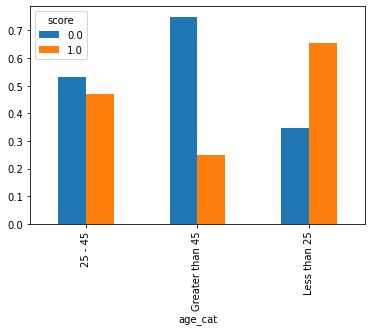

In [6]:
# Croisement Tranche d'âge - Score du modèle
(
    pd.crosstab(df_compas.age_cat, df_compas.score, normalize="index")
    .plot.bar()
)

**Quelques observations**

Ces observations font l'hypothèse que les données des différents sous-groupes sont représentatives des populations étudiées et que les sous-groupes comparés sont comparables.

- **Origine ethnique** :Les afro-américains et les populations indigènes sont majoritairement prédits à risque élevé par le modèle. Ceci n'est pas le cas des autres modalités.
- **Sexe**: Le score du modèle a quasiment la même répartition par rapport au sexe.
- **Âge**: Selon le modèle, le risque de récidivisme a l'air d'être fortement corrélé à l'âge. La majorité des personnes de moins de 25 ans sont à risque élevé.

L'un des arguments qui reviennent souvent est **"Et si ça correspond à la réalité?"**

L'analyse qui vient d'être réalisée correspond à l'analyse de la sortie du modèle. Les sources de biais dans un pipeline de modélisation sont légion.

<center><img src="../themes/aequitas_bias_pipeline.png"/></center>
<center><figcaption>Fig.4 - Sources de biais - Source: Aequitas AAAI 2021</figcaption></center>


### 2.3.2. Croisement avec le label

Le croisement des variables sensibles avec le label permet de voir si on a les mêmes distributions que celles obtenues en croisant les variables sensibles avec le score en sortie du modèle.
Par contre, il est important de souligner l'une limites du label dont on dispose. Alors que le modèle prédit le risque de récidivisme, un label égal à 1 correspond correspond à une infraction jugée ainsi. 
- Si la présence des patrouilles de police est renforcée dans des quartiers à dominante afro-américaines, la prévalence de récidive dans cette population va augmenter.
- Le label ne peut être calculé que pour des personnes qui ont récidivé. Le score ne peut pas être calculé pour les personnes ayant commis un premier crime et qui ont eu de lourdes peines -e.g. personnes condamnées à des dizaines d'année de prison ou à vie-. 

<AxesSubplot:xlabel='race'>

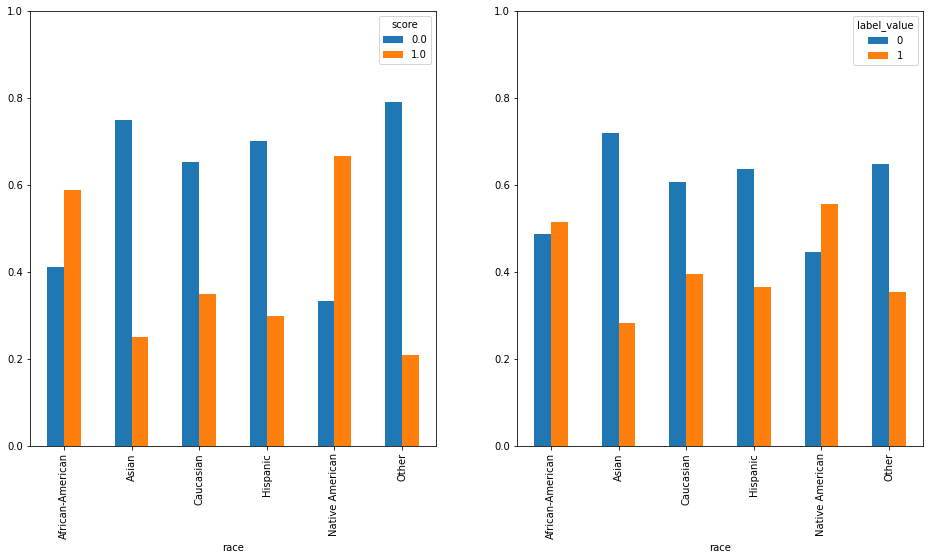

In [7]:
# Croisement origine ethnique - Score du modèle & label
fig, axes = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)

(
    pd.crosstab(df_compas.race, df_compas.score, normalize="index")
    .plot.bar(ax=axes[0], ylim=(0, 1))
)

(
    pd.crosstab(df_compas.race, df_compas.label_value, normalize="index")
    .plot.bar(ax=axes[1], ylim=(0, 1))
)


<AxesSubplot:xlabel='sex'>

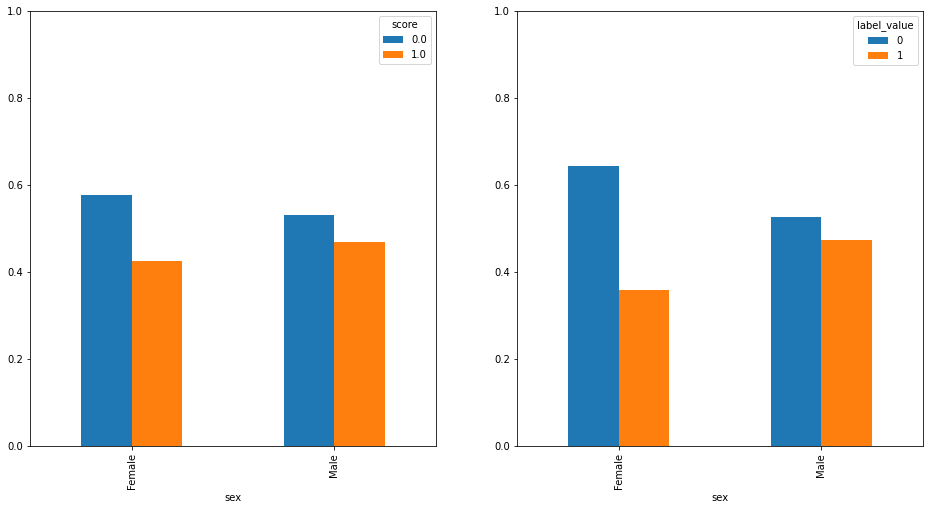

In [8]:
# Croisement Sexe - Score du modèle & label
fig, axes = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)

(
    pd.crosstab(df_compas.sex, df_compas.score, normalize="index")
    .plot.bar(ax=axes[0], ylim=(0, 1))
)

(
    pd.crosstab(df_compas.sex, df_compas.label_value, normalize="index")
    .plot.bar(ax=axes[1], ylim=(0, 1))
)

<AxesSubplot:xlabel='age_cat'>

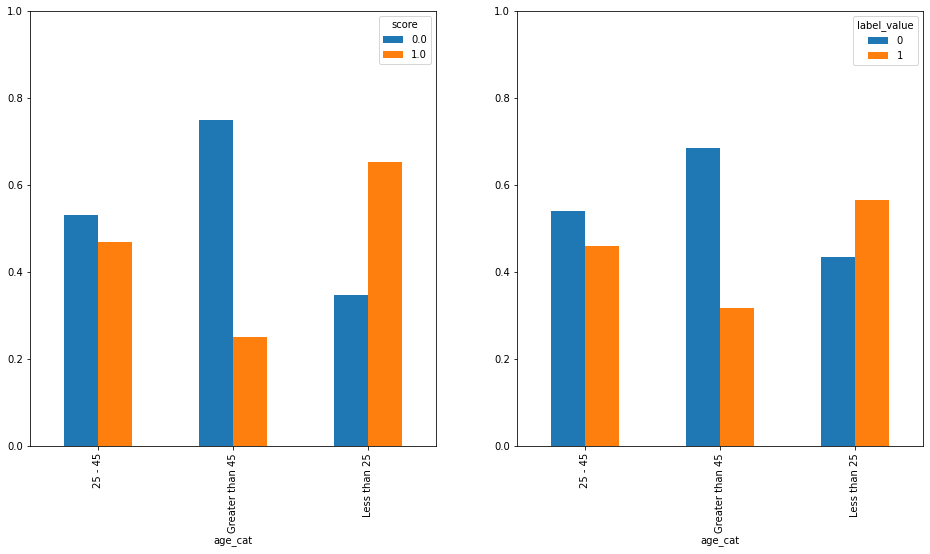

In [9]:
# Croisement Âge - Score du modèle & label
fig, axes = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)

(
    pd.crosstab(df_compas.age_cat, df_compas.score, normalize="index")
    .plot.bar(ax=axes[0], ylim=(0, 1))
)

(
    pd.crosstab(df_compas.age_cat, df_compas.label_value, normalize="index")
    .plot.bar(ax=axes[1], ylim=(0, 1))
)

D'après ces visualisations, on constate par exemple que le pourcentage des afro-américains et des populations indigènes à risque élevé de récidivisme est bien plus élevé que la réalité.

Les métriques et les méthodes mises à disposition dans Aequitas permettent de **quantifier cet écart et de le qualifier de biais ou pas selon la définition d'équité choisie**.

## 2.4. L' utilisation de `Group`

### 2.4.1. Calcul des métriques de groupe

In [10]:
from aequitas.group import Group

La classe `Group` permet de **définir les variables à protéger** et de **calculer plusieurs métriques de groupe**.
Les métriques à calculer peuvent être choisies au moment de l'instanciation d'un objet de la classe `Group`.

🚨🚨🚨 A l'image du choix des métriques dans un problème de modélisation, différentes métriques peuvent être inspectées afin mieux appréhender les limites du modèle. Par contre, les métriques choisies pour évaluer le biais doivent correspondre à la définition de l'équité choisie en amont du calcul.

🚨🚨🚨 **Les différentes définitions d'équité ne peuvent pas toutes être respectées en même temps**. Pour plus d'éléments sur ce point, veuillez vous référer à:
- [21 fairness definitions and their politics](https://www.youtube.com/results?search_query=21+fairness+definitions)
- [Fair prediction with disparate impact](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf)

> If an instrument satisfies **predictive parity** but the **prevalence differs between groups**, the instrument **cannot achieve equal false positive and false negative rates across those groups**.<br><br>
From *Fair Prediction with disparate impact* - *Alexandra Chouldechova*

La méthode `get_crosstabs` permet de calculer les métriques de groupe pour chaque variable à protéger. Deux types de métriques sont calculés:
- Les **[comptages](https://dssg.github.io/aequitas/examples/compas_demo.html#Group-Counts-Calculated:)**: Nombre de vrais positifs, nombre de faux positifs, etc.
- Les **[ratios](https://dssg.github.io/aequitas/examples/compas_demo.html#Absolute-Metrics-Calculated:)**: Taux de faux positifs, précision, etc.

In [13]:
g = Group()
grp_table, protected_attributes = g.get_crosstabs(df_compas, attr_cols=["race", "sex", "age_cat"])

In [14]:
grp_table.round(2)

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,3317,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,2174,1522,0.66,0.59,805,532,990,1369,1901,1795,3696,7214,0.51
1,0,binary 0/1,3317,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,8,24,0.00,0.25,2,3,21,6,9,23,32,7214,0.28
2,0,binary 0/1,3317,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,854,1600,0.26,0.35,349,461,1139,505,966,1488,2454,7214,0.39
3,0,binary 0/1,3317,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,190,447,0.06,0.30,87,129,318,103,232,405,637,7214,0.36
4,0,binary 0/1,3317,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,12,6,0.00,0.67,3,1,5,9,10,8,18,7214,0.56
5,0,binary 0/1,3317,race,Other,0.32,0.85,0.30,0.46,0.15,0.68,0.70,0.54,79,298,0.02,0.21,36,90,208,43,133,244,377,7214,0.35
6,0,binary 0/1,3317,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,591,804,0.18,0.42,288,195,609,303,498,897,1395,7214,0.36
7,0,binary 0/1,3317,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,2726,3093,0.82,0.47,994,1021,2072,1732,2753,3066,5819,7214,0.47
8,0,binary 0/1,3317,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,1924,2185,0.58,0.47,741,706,1479,1183,1889,2220,4109,7214,0.46
9,0,binary 0/1,3317,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,394,1182,0.12,0.25,181,285,897,213,498,1078,1576,7214,0.32


### 2.4.2. Plotting des métriques

Pour tracer les métriques issues des calculs de `Group`, il existe deux méthodes dans la classe `Plot`.
- `plot_group_metric`: trace la valeur de la métrique en question pour chaque sous-groupe des variables à protéger.
- `plot_group_metric_all`: trace plusieurs pour chaque sous-groupe des variables à protéger.

In [15]:
from aequitas.plotting import Plot

In [16]:
aq_plot = Plot()

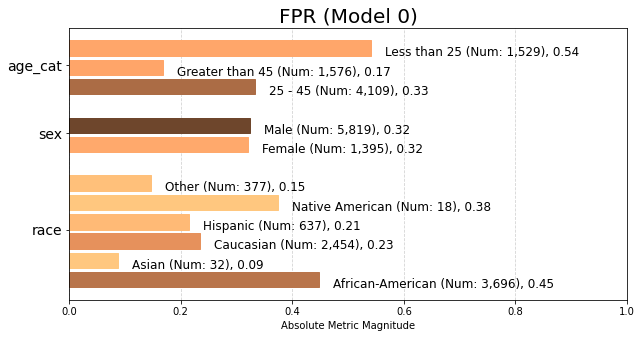

In [31]:
fpr = aq_plot.plot_group_metric(group_table=grp_table,
                               group_metric="fpr")

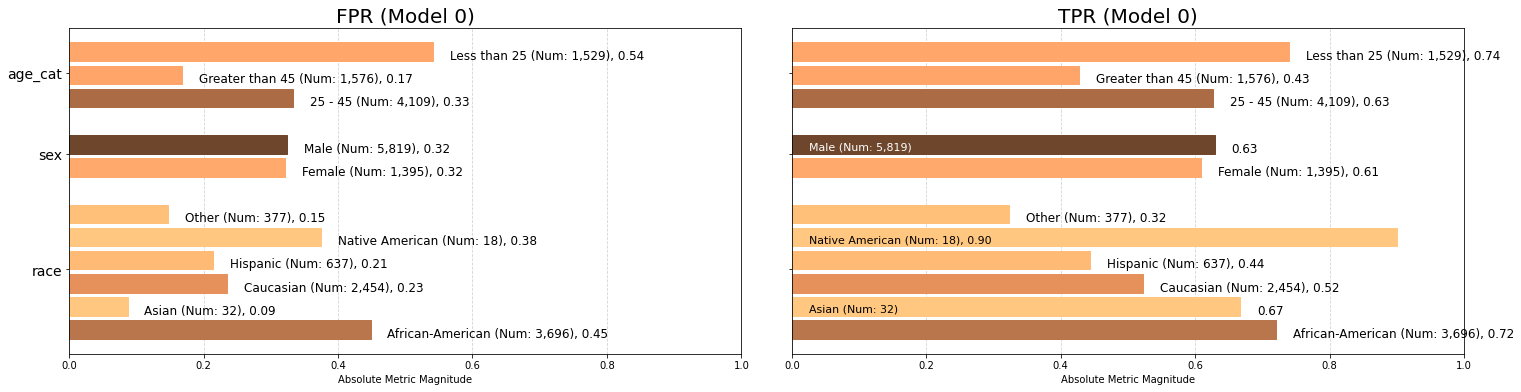

<Figure size 432x288 with 0 Axes>

In [32]:
fpr_tpr_plot = aq_plot.plot_group_metric_all(grp_table, metrics=["fpr", "tpr"], ncols=2)

## 2.5. L' utilisation de `Bias`

### 2.5.1. Calcul des disparités

La classe `Group` permet de calculer différentes métriques pour chaque sous-groupe. A partir de ces résultats, la classe `Bias` permet de calculer des **ratios de disparité**.

Un **ratio de disparité** pour une métrique donnée correspond au ratio de la métrique pour un sous-groupe donné et la métrique pour le **groupe de référence**. Les groupes de référence sont choisis selon la problématique en question.

Dans le cas où:
- Métrique d'intérêt: taux de faux positifs (FPR)
- la variable à protéger: *origines ethniques*
- la classe de référence: *Caucasian*

La disparité avec les autres sous-groupes est définie de la façon suivante:

$$Disparity_{FPR} = \frac{ FPR_{group} } { FPR_{Caucasian} }$$

🚨🚨🚨 Il est important de noter que d'autres définitions de disparité existent dans la littérature.

In [33]:
from aequitas.bias import Bias

In [34]:
aq_bias = Bias()

Il existe trois méthodes pour calculer les disparités:
- `get_disparity_predefined_groups`: permet de calculer les ratios de disparité en définissant les groupes de référence pour chaque variable à protéger.
- `get_disparity_min_metric`: le groupe de référence est celui avec la valeur min de la métrique en question parmi tous les groupes de la variable à protéger.
- `get_disparity_major_group`: le groupe de référence est celui avec le maximum de lignes dans le jeu de données.

In [36]:
bias_dpg = aq_bias.get_disparity_predefined_groups(grp_table, 
                                           original_df=df_compas, 
                                           ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'})

get_disparity_predefined_group()


In [37]:
bias_dpg

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,3317,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1901,1795,3696,7214,0.514340,2.545667,1.690224,1.064904,0.906085,1.213154,1.912093,0.586416,1.377549,0.720526,0.913728,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
1,0,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125000,0.250000,0.086957,0.333333,0.875000,0.750000,8,24,0.002412,0.250000,2,3,21,6,9,23,32,7214,0.281250,0.009368,0.718384,1.268317,0.611748,0.433839,0.370749,0.698482,1.275248,1.192808,1.229148,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
2,0,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
3,0,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057281,0.298273,87,129,318,103,232,405,637,7214,0.364207,0.222482,0.857099,0.916748,1.120464,1.001616,0.915887,1.165140,0.849249,1.025773,0.999346,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
4,0,binary 0/1,3317,race,Native American,0.900000,0.625000,0.166667,0.250000,0.375000,0.100000,0.833333,0.750000,12,6,0.003618,0.666667,3,1,5,9,10,8,18,7214,0.555556,0.014052,1.915691,1.268317,0.611748,0.578453,1.598854,0.209544,1.721584,0.816506,1.170618,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
5,0,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023817,0.209549,36,90,208,43,133,244,377,7214,0.352785,0.092506,0.602147,0.920466,1.115085,1.048203,0.629057,1.417970,0.618447,1.113660,0.980490,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
6,0,binary 0/1,3317,sex,Female,0.608434,0.678930,0.242537,0.487310,0.321070,0.391566,0.757463,0.512690,591,804,0.178173,0.423656,288,195,609,303,498,897,1395,7214,0.356989,0.216801,0.904348,0.806925,1.336425,0.734738,0.990343,1.055810,0.967101,1.004633,1.130710,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
7,0,binary 0/1,3317,sex,Male,0.629132,0.675799,0.330100,0.364637,0.324201,0.370868,0.669900,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
8,0,binary 0/1,3317,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,1924,2185,0.580042,0.468240,741,706,1479,1183,1889,2220,4109,7214,0.459723,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45
9,0,binary 0/1,3317,age_cat,Greater than 45,0.427711,0.832096,0.241117,0.459391,0.167904,0.572289,0.758883,0.540609,394,1182,0.118782,0.250000,181,285,897,213,498,1078,1576,7214,0.315990,0.204782,0.533914,0.879232,1.192804,0.746232,0.503031,1.531238,0.682963,1.248989,1.121136,25 - 45,25 - 45,25 - 45,25 

### 2.5.2. Plotting des disparités

In [46]:
import aequitas.plot as ap 

In [49]:
ap.disparity(bias_dpg, ["fpr", "fnr"], 'race', fairness_threshold = 1.2)

alt.LayerChart(...)